In [1]:
# Packages
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.cross_decomposition import PLSRegression
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.linear_model import LogisticRegression

In [2]:
# Environment variables
PROJECTPATH = os.getenv('PROJECTPATH')

In [3]:
def prepare_data(clusters, scores, demographics, threshold = 0.5):
    
    # Compute completion rate for the different assessments
    nparticipants = scores.shape[0]
    completion = dict()
    for col, vals in scores.items():
        if col != 'Subject_ID':
            completion[col] = vals.notna().sum()/nparticipants
            
    # Filter scales above completion threshold
    scales = [col for col, val in completion.items() if val > threshold]        
    
    # Get the scores for the subset of scales
    scores_subset = scores[scales].copy()
    scores_subset['Subject_ID'] = scores['Subject_ID']
    
    # Join scores and cluster information
    clusters_scores = clusters.copy()
    clusters_scores = (clusters_scores
     .rename(columns = {'ID':'file'})
     .loc[:, ['file', 'nk2']]
     .merge(demographics, how = 'left', on = 'file'))

    # Filter for POND
    clusters_scores = clusters_scores.loc[clusters_scores['Dataset'] == 'POND']

    # Clean up IDs for merging
    clusters_scores['Subject_ID'] = (clusters_scores['Subject_ID']
                                     .str.replace('sub-', '')
                                     .astype(int))

    # Merge clusters to scores
    clusters_scores = (clusters_scores
                       .loc[:, ['Subject_ID', 'nk2']]
                       .merge(scores_subset, on = 'Subject_ID', how = 'left'))

    # Keep only complete observations
    clusters_scores = clusters_scores.dropna()
    
    # Create the input matrix and binary targets
    X = clusters_scores.drop(['Subject_ID', 'nk2'], axis = 1).to_numpy()
    y = np.array(clusters_scores['nk2'], dtype = int)-1
    
    return X,y
    

In [4]:
# Parameter set ID
params_id = 700

# Output directory
output_dir = os.path.join('outputs', 'human_clinical_multivariate', 'v3', str(params_id))
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# Input directories
registration_dir = 'data/human/registration/v3/'
pipeline_dir = 'data/human/derivatives/v3/'

registration_dir = os.path.join(PROJECTPATH, registration_dir)
pipeline_dir = os.path.join(PROJECTPATH, pipeline_dir, str(params_id))

# Demographics file
demographics = os.path.join(registration_dir, 'subject_info', 'demographics.csv')
demographics = pd.read_csv(demographics)

# POND clinical scores
scores = os.path.join(registration_dir, 'subject_info', 'POND', 'POND_clinical_scores_20230915.csv')
scores = pd.read_csv(scores)

# Cluster solutions
cluster_dir = os.path.join(pipeline_dir, 'clusters', 'resolution_3.0')
cluster_file = os.path.join(cluster_dir, 'clusters.csv')
clusters = pd.read_csv(cluster_file)

In [5]:
# Drop columns
cols_to_drop = ['Unnamed: 0', 'site', 'SUB_ID', 
                'DOB', 'PRIMARY_DIAGNOSIS', 
                'RESEARCH_CONFIRM_DIAG', 
                'HSHLD_INCOME_STD', 
                'PRMY_CGVR_STD',
               'SWANPDOC', 'TPOCSPDOC']
scores = scores.drop(cols_to_drop, axis = 1)

# Drop columns containing the following strings
strings_to_drop = ['NSI', 'ETHNCTY', 'EDUC']
for s in strings_to_drop:
    scores = scores.loc[:, ~scores.columns.str.contains(s)]

# Rename the subject ID column for merging
scores = scores.rename(columns = {'subject':'Subject_ID'})

# Assign NaN to missing values 999 code
for col, vals in scores.items():
    x = vals.copy()
    x[x == 999] = np.nan
    scores[col] = x

scores.head()

,Subject_ID,CB68IPTS,CB68EPTS,CBIPTS,CBEPTS,AB21GCCS,BOT2_BLTC_SS,BOT2_BAL_SS,BOT2_BDYC_STDS,KKID_TOT,...,MT_ST_MCRTT,MT_ST_CRTSDT,MT_ST_PSIT,MT_ST_SSRTT,MT_ST_ITSSRT,MT_ST_PSRRT,ADHD_I_SUB,ADHD_HI_SUB,TPOCS_TOT,FSIQ
0,880002,50.0,50.0,NaN,NaN,91.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,0.0,1.0,NaN
1,880019,72.0,68.0,NaN,NaN,67.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,7.0,8.0,20.0,74.0
2,880020,65.0,65.0,NaN,NaN,69.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-47.0,76.0
3,880023,70.0,74.0,NaN,NaN,72.0,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,9.0,4.0,-11.0,98.0
4,880043,75.0,54.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,4.0,4.0,31.0,NaN


In [19]:
thresholds = [0.2, 0.4, 0.6, 0.8]
list_nscales = []
list_nparticipants = []
dict_auc = {key:None for key in thresholds}
for threshold in thresholds:

    # Get inputs and labels
    X,y = prepare_data(clusters = clusters, 
                       scores = scores, 
                       demographics = demographics,
                       threshold = threshold)

    nscales = X.shape[1]
    nparticipants = X.shape[0]

    list_nscales.append(nscales)
    list_nparticipants.append(X.shape[0])

    # Maximum number of components
    max_components = X.shape[1]-1
    
    # Iterate over components
    component_range = range(2, max_components)
    list_auc = []
    for nc in component_range:

        # Initiatlize the PLSR module
        plsr = PLSRegression(n_components = nc, scale = False)

        # Fit the model to the data
        plsr.fit(X, y)

        # Predict cluster labels
        y_pred = plsr.predict(X)

        # Clamp the interval since this isn't a proper classifier
        y_pred[y_pred > 1.0] = 1.0
        y_pred[y_pred < 0] = 0

        # Obtain ROC metrics
        fpr, tpr, roc_thresholds = roc_curve(y, y_pred)

        # Compute AUC
        auc = roc_auc_score(y, y_pred)
        list_auc.append(auc)

        # Plot the ROC curve for a subset of components
        if nc in np.linspace(2, max_components, num = 5, dtype = int):
            plt.plot(fpr, tpr, label = '{} (AUC = {:.2f})'.format(nc, auc))

    # Save AUC values at this threshold
    dict_auc[threshold] = [component_range, list_auc]
            
    # Complete the ROC curve plot for this threshold
    plt.plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), 
             linestyle = '--', label = 'Chance level (AUC = 0.5)', 
            color = "black")
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('Completion threshold: {}; Scales: {}; Participants: {}'.format(threshold, nscales, nparticipants))
    plt.legend(title = "Number of components")

    # Output file
    outfile = 'PLSDA_nk2_ROC_threshold_{}.png'.format(threshold)
    outfile = os.path.join(output_dir, outfile)
    plt.savefig(outfile, dpi = 300)

    plt.close()

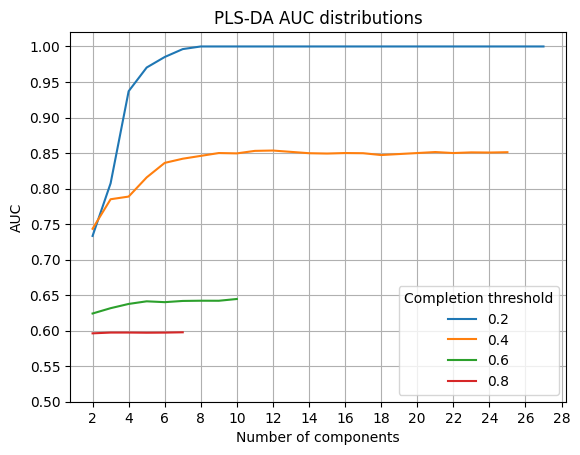

In [15]:
# Plot the AUC per components for different thresholds
for key, val in dict_auc.items():
    plt.plot(val[0], val[1], label = key)
    
plt.xlabel("Number of components")
plt.ylabel("AUC")
plt.xticks(range(2, 30, 2))
plt.yticks(np.arange(0.5, 1.05, 0.05))
plt.legend(title = "Completion threshold")
plt.title("PLS-DA AUC distributions")
plt.grid()

# Output file
outfile = 'PLSDA_nk2_AUC.png'.format(threshold)
outfile = os.path.join(output_dir, outfile)
plt.savefig(outfile, dpi = 300)

In [ ]:
# Create the input matrix and binary targets
X = clusters_scores.drop(['Subject_ID', 'nk2'], axis = 1).to_numpy()
y = np.array(clusters_scores['nk2'], dtype = int)-1

# Initiatlize the PLSR module
plsr = PLSRegression(n_components = 2, scale = False)

# Fit the model to the data
plsr.fit(X, y)

# Transform the input space to the latent space
X_pls = plsr.transform(X)

In [ ]:
outfile = 'PLSDA_nk2_latent_space.png'
outfile = os.path.join(output_dir, outfile)

plt.scatter(X_pls[y == 0, 0], X_pls[y == 0, 1], label = 'k = 1')
plt.scatter(X_pls[y == 1, 0], X_pls[y == 1, 1], label = 'k = 2')
plt.xlabel("Latent variable 1")
plt.ylabel("Latent variable 2")
plt.legend()

plt.savefig(outfile, dpi = 300)

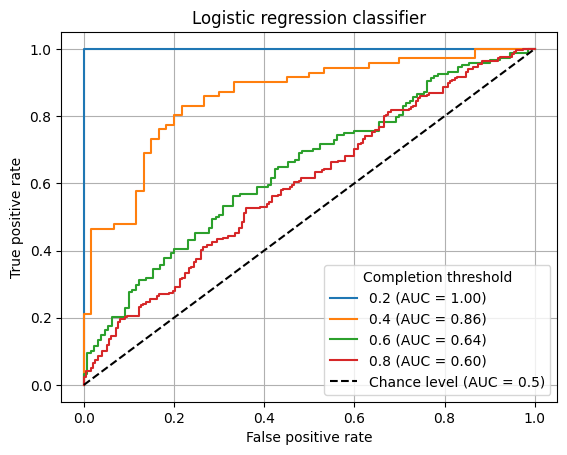

In [18]:
for threshold in thresholds:

    # Get inputs and labels
    X,y = prepare_data(clusters = clusters, 
                       scores = scores, 
                       demographics = demographics,
                       threshold = threshold)

    LR = LogisticRegression(penalty = 'none', solver = 'newton-cg')
    LR.fit(X, y)

    y_pred_probs = LR.predict_proba(X)
    y_pred_probs = y_pred_probs[:,1]

    fpr, tpr, roc_thresholds = roc_curve(y, y_pred_probs)

    auc = roc_auc_score(y, y_pred_probs)

# outfile = 'PLSDA_nk2_ROC.png'
# outfile = os.path.join(output_dir, outfile)

    plt.plot(fpr, tpr, label = '{} (AUC = {:.2f})'.format(threshold, auc))

plt.plot(np.linspace(0, 1, 50), np.linspace(0, 1, 50), 
         linestyle = '--', label = 'Chance level (AUC = 0.5)', color = "black")
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title("Logistic regression classifier")
plt.legend(title = "Completion threshold")
plt.grid()

outfile = 'LR_nk2.png'
outfile = os.path.join(output_dir, outfile)
plt.savefig(outfile, dpi = 300)